In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

In [3]:
# Load data
games = pd.read_csv("data/MRegularSeasonCompactResults.csv")  
seeds = pd.read_csv("data/MNCAATourneySeeds.csv")
rankings = pd.read_csv("data/MMasseyOrdinals.csv")
teams = pd.read_csv("data/MTeams.csv")
game_details = pd.read_csv("data/MRegularSeasonDetailedResults.csv") 
seasons = pd.read_csv("data/MSeasons.csv")

In [4]:
# Define seasons for training and prediction
TRAIN_SEASON = 2024
PREDICT_SEASON = 2025

# Get the current ranking day from 2025 season - this will be our reference point
CURRENT_RANKING_DAY = rankings[rankings['Season'] == PREDICT_SEASON]['RankingDayNum'].max()

print(f"Using RankingDayNum {CURRENT_RANKING_DAY} from 2025 season as reference point")

# Function to get the most recent ranking before each game day
def get_rankings_before_gameday(rankings_df, game_day, season):
    # Filter for the season first
    season_rankings = rankings_df[rankings_df['Season'] == season]
    
    # Get all ranking days that are before or equal to the game day
    valid_ranking_days = season_rankings[
        season_rankings['RankingDayNum'] <= game_day
    ]['RankingDayNum'].unique()
    
    if len(valid_ranking_days) == 0:
        return None
    
    # Get the most recent ranking day
    most_recent_day = valid_ranking_days.max()
    
    # Get rankings from that day
    return season_rankings[season_rankings['RankingDayNum'] == most_recent_day]

# For training data, filter 2024 season and use same day number as 2025
train_games = games[
    (games["Season"] == TRAIN_SEASON) & 
    (games["DayNum"] <= CURRENT_RANKING_DAY)
]

# Get unique game days
train_game_days = sorted(train_games['DayNum'].unique())

# Get rankings for each game day
train_rankings_by_day = []
for day in train_game_days:
    day_rankings = get_rankings_before_gameday(rankings, day, TRAIN_SEASON)
    if day_rankings is not None:
        train_rankings_by_day.append(day_rankings)

train_rankings = pd.concat(train_rankings_by_day) if train_rankings_by_day else pd.DataFrame()
train_seeds = seeds[seeds["Season"] == TRAIN_SEASON]

# Do the same for prediction data
predict_games = games[games["Season"] == PREDICT_SEASON]
predict_game_days = sorted(predict_games['DayNum'].unique())

predict_rankings_by_day = []
for day in predict_game_days:
    day_rankings = get_rankings_before_gameday(rankings, day, PREDICT_SEASON)
    if day_rankings is not None:
        predict_rankings_by_day.append(day_rankings)

predict_rankings = pd.concat(predict_rankings_by_day) if predict_rankings_by_day else pd.DataFrame()
predict_seeds = seeds[seeds["Season"] == PREDICT_SEASON]

# Verify the filtering worked
print("\nData Summary:")
print(f"Number of 2024 games up to day {CURRENT_RANKING_DAY}:", len(train_games))
print("Number of 2024 seeds:", len(train_seeds))
print("Number of 2024 teams with rankings:", len(train_rankings["TeamID"].unique()) if not train_rankings.empty else 0)
print("Number of 2025 teams with rankings:", len(predict_rankings["TeamID"].unique()) if not predict_rankings.empty else 0)

# Print sample of rankings progression
print("\nSample of rankings progression for 2024:")
sample_days = sorted(train_game_days)[:5]  # First 5 game days
for day in sample_days:
    rankings_for_day = get_rankings_before_gameday(rankings, day, TRAIN_SEASON)
    print(f"\nDay {day} rankings available:", "Yes" if rankings_for_day is not None else "No")
    if rankings_for_day is not None:
        print("Number of teams ranked:", len(rankings_for_day['TeamID'].unique()))
        print("Sample of rankings:")
        print(rankings_for_day.head(3))

Using RankingDayNum 128 from 2025 season as reference point

Data Summary:
Number of 2024 games up to day 128: 5491
Number of 2024 seeds: 68
Number of 2024 teams with rankings: 362
Number of 2025 teams with rankings: 364

Sample of rankings progression for 2024:

Day 0 rankings available: No

Day 1 rankings available: No

Day 2 rankings available: No

Day 3 rankings available: No

Day 4 rankings available: No


In [5]:
# Create region mapping dictionary for 2024 and 2025
region_map_2024 = {
    'W': seasons[seasons['Season'] == TRAIN_SEASON]['RegionW'].iloc[0],
    'X': seasons[seasons['Season'] == TRAIN_SEASON]['RegionX'].iloc[0],
    'Y': seasons[seasons['Season'] == TRAIN_SEASON]['RegionY'].iloc[0],
    'Z': seasons[seasons['Season'] == TRAIN_SEASON]['RegionZ'].iloc[0]
}

region_map_2025 = {
    'W': seasons[seasons['Season'] == PREDICT_SEASON]['RegionW'].iloc[0],
    'X': seasons[seasons['Season'] == PREDICT_SEASON]['RegionX'].iloc[0],
    'Y': seasons[seasons['Season'] == PREDICT_SEASON]['RegionY'].iloc[0],
    'Z': seasons[seasons['Season'] == PREDICT_SEASON]['RegionZ'].iloc[0]
}

# Create explicit copies of seeds DataFrames
train_seeds = seeds[seeds['Season'] == TRAIN_SEASON].copy()
predict_seeds = seeds[seeds['Season'] == PREDICT_SEASON].copy()

# Extract seed values and region information
train_seeds.loc[:, 'SeedValue'] = train_seeds['Seed'].str.extract('(\d+)').astype(float)
train_seeds.loc[:, 'Region'] = train_seeds['Seed'].str[0]
train_seeds.loc[:, 'RegionName'] = train_seeds['Region'].map(region_map_2024)

predict_seeds.loc[:, 'SeedValue'] = predict_seeds['Seed'].str.extract('(\d+)').astype(float)
predict_seeds.loc[:, 'Region'] = predict_seeds['Seed'].str[0]
predict_seeds.loc[:, 'RegionName'] = predict_seeds['Region'].map(region_map_2025)

# Create team features using the rankings we prepared earlier
if not train_rankings.empty:
    train_team_features = train_rankings.copy()
    train_team_features = train_team_features.merge(
        train_seeds[['TeamID', 'SeedValue', 'RegionName']], 
        on='TeamID', 
        how='left'
    )
else:
    print("Warning: No training rankings data available")
    train_team_features = pd.DataFrame()

if not predict_rankings.empty:
    predict_team_features = predict_rankings.copy()
    predict_team_features = predict_team_features.merge(
        predict_seeds[['TeamID', 'SeedValue', 'RegionName']], 
        on='TeamID', 
        how='left'
    )
else:
    print("Warning: No prediction rankings data available")
    predict_team_features = pd.DataFrame()

# Print summary of the merged data
print("\nFeature Data Summary:")
print(f"Training features shape: {train_team_features.shape}")
print(f"Prediction features shape: {predict_team_features.shape}")

# Show sample of the features
if not train_team_features.empty:
    print("\nSample of training team features:")
    print(train_team_features.head(3))


Feature Data Summary:
Training features shape: (1938472, 7)
Prediction features shape: (1883798, 7)

Sample of training team features:
   Season  RankingDayNum SystemName  TeamID  OrdinalRank  SeedValue RegionName
0    2024              9         AP    1104           22        4.0       West
1    2024              9         AP    1112            3        2.0       West
2    2024              9         AP    1116           14        NaN        NaN


In [9]:
print(predict_team_features.head(25))

    Season  RankingDayNum SystemName  TeamID  OrdinalRank  SeedValue  \
0     2025              9         AP    1104            2        2.0   
1     2025              9         AP    1112            9        4.0   
2     2025              9         AP    1116           18       10.0   
3     2025              9         AP    1120            5        1.0   
4     2025              9         AP    1124           12        9.0   
5     2025              9         AP    1153           17        NaN   
6     2025              9         AP    1163            3        8.0   
7     2025              9         AP    1166           14        9.0   
8     2025              9         AP    1181            6        1.0   
9     2025              9         AP    1196           20        1.0   
10    2025              9         AP    1211            4        8.0   
11    2025              9         AP    1222            8        1.0   
12    2025              9         AP    1231           16       

In [7]:
# Verify the filtering worked
print("Number of games for 2024:", len(train_games))
print("Number of seeds for 2024:", len(train_seeds))
print("Number of games for 2025:", len(predict_games))
print("Number of seeds for 2025:", len(predict_seeds))
       

Number of games for 2024: 5491
Number of seeds for 2024: 68
Number of games for 2025: 5641
Number of seeds for 2025: 68


In [10]:
# Define the preferred ranking systems
preferred_systems = ["SAG", "TPR", "MAS", "RDT", "ESR", "POM", "USA", "AP"]

# Function to calculate slope with improved error handling
def calculate_slope(group):
    if len(group) < 2:  # If only one data point, return 0 slope
        return 0
    
    x = group.index.astype(float)  # RankingDayNum as x
    y = group.values
    
    # Remove any NaN or infinite values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    
    if len(x) < 2:  # Recheck after cleaning
        return 0
        
    # Normalize x to prevent numerical issues
    x = (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x
    
    # Suppress all warnings during polyfit
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        coefficients = np.polyfit(x, y, 1)
    
    return coefficients[0]  # Return slope

# Add warning suppression at the top
import warnings
import numpy as np

# Process training rankings (2024)
train_rankings_pivot = (train_rankings
    .sort_values('RankingDayNum')  # Ensure chronological order
    .groupby(['TeamID', 'SystemName'])
    .apply(lambda x: calculate_slope(x['OrdinalRank']))
    .unstack()
)

# Process prediction rankings (2025)
predict_rankings_pivot = (predict_rankings
    .sort_values('RankingDayNum')  # Ensure chronological order
    .groupby(['TeamID', 'SystemName'])
    .apply(lambda x: calculate_slope(x['OrdinalRank']))
    .unstack()
)

# Filter for only the available preferred systems in each dataset
available_systems_train = [sys for sys in preferred_systems if sys in train_rankings_pivot.columns]
available_systems_predict = [sys for sys in preferred_systems if sys in predict_rankings_pivot.columns]

train_rankings_pivot = train_rankings_pivot[available_systems_train]
predict_rankings_pivot = predict_rankings_pivot[available_systems_predict]

# Normalize slopes to -1 to 1 scale where positive means improving rank (getting better)
for column in train_rankings_pivot.columns:
    max_abs = np.abs(train_rankings_pivot[column]).max()
    if max_abs != 0:
        train_rankings_pivot[column] = train_rankings_pivot[column] / max_abs

for column in predict_rankings_pivot.columns:
    max_abs = np.abs(predict_rankings_pivot[column]).max()
    if max_abs != 0:
        predict_rankings_pivot[column] = predict_rankings_pivot[column] / max_abs

# Print the first 25 rows of each rankings pivot table
print("2024 Training Rankings (Slopes):")
print(train_rankings_pivot.head(25))
print("\n2025 Prediction Rankings (Slopes):")
print(predict_rankings_pivot.head(25))

/var/folders/gc/_00hl__j42163556kvkzz4b40000gq/T/ipykernel_45653/2737154623.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_slope(x['OrdinalRank']))


2024 Training Rankings (Slopes):
SystemName       TPR       MAS       ESR       POM           USA        AP
TeamID                                                                    
1101        0.056738  0.438088 -0.227115  0.584629           NaN       NaN
1102       -0.251635  0.405596  0.213000  0.510817           NaN       NaN
1103       -0.079453  0.071389  0.121493 -0.029400           NaN       NaN
1104       -0.071515 -0.062057 -0.278103 -0.016916 -2.880900e-01 -0.324457
1105       -0.074063 -0.038123  0.006309 -0.069331           NaN       NaN
1106        0.233161 -0.026817  0.876480 -0.247337           NaN       NaN
1107        0.183050  0.188995  0.583338 -0.133127           NaN       NaN
1108       -0.219302 -0.066665 -0.489382  0.134644           NaN       NaN
1110        0.005167 -0.135547  0.403174 -0.129251           NaN       NaN
1111        0.013155 -0.830813 -0.178607 -0.296012           NaN       NaN
1112        0.016548  0.024741  0.008350 -0.001978  3.424153e-01  0

/var/folders/gc/_00hl__j42163556kvkzz4b40000gq/T/ipykernel_45653/2737154623.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_slope(x['OrdinalRank']))


In [11]:
print("\n2024 Train Rankings (Slopes):")
print(train_rankings_pivot.head(25))


2024 Train Rankings (Slopes):
SystemName       TPR       MAS       ESR       POM           USA        AP
TeamID                                                                    
1101        0.056738  0.438088 -0.227115  0.584629           NaN       NaN
1102       -0.251635  0.405596  0.213000  0.510817           NaN       NaN
1103       -0.079453  0.071389  0.121493 -0.029400           NaN       NaN
1104       -0.071515 -0.062057 -0.278103 -0.016916 -2.880900e-01 -0.324457
1105       -0.074063 -0.038123  0.006309 -0.069331           NaN       NaN
1106        0.233161 -0.026817  0.876480 -0.247337           NaN       NaN
1107        0.183050  0.188995  0.583338 -0.133127           NaN       NaN
1108       -0.219302 -0.066665 -0.489382  0.134644           NaN       NaN
1110        0.005167 -0.135547  0.403174 -0.129251           NaN       NaN
1111        0.013155 -0.830813 -0.178607 -0.296012           NaN       NaN
1112        0.016548  0.024741  0.008350 -0.001978  3.424153e-01  0.2

In [12]:
# Function to get last n games' win rate for a specific season
def get_last_n_games_win_rate(team_id, season, n=10):
    season_games = games[games["Season"] == season]
    recent_games = season_games[
        ((season_games["WTeamID"] == team_id) | (season_games["LTeamID"] == team_id)) & 
        (season_games["DayNum"] <= CURRENT_RANKING_DAY)
    ]
    recent_games = recent_games.tail(n)
    wins = (recent_games["WTeamID"] == team_id).sum()
    return wins / n if len(recent_games) > 0 else 0.5  # Default to 50% if no games

# Create team features for training data (2024)
train_team_features = train_seeds.merge(train_rankings_pivot, on="TeamID", how="left").fillna(0)

# Add win rates for training teams using CURRENT_RANKING_DAY to match prediction timeframe
train_team_features["Last10WinRate"] = train_team_features["TeamID"].apply(
    lambda team: get_last_n_games_win_rate(team, TRAIN_SEASON)
)

# Create team features for prediction data (2025) 
predict_team_features = predict_seeds.merge(predict_rankings_pivot, on="TeamID", how="left").fillna(0)
#predict_team_features = predict_team_features.reset_index()  # This will make TeamID a regular column

# Add win rates for prediction teams using current point in season
predict_team_features["Last10WinRate"] = predict_team_features["TeamID"].map(
    lambda team: get_last_n_games_win_rate(team, PREDICT_SEASON)
)

# Get available systems for each dataset
available_systems_predict = [col for col in predict_rankings_pivot.columns if col != 'TeamID']

# Print verification of features
print(f"Using games up to day {CURRENT_RANKING_DAY} for win rate calculations\n")
print("2024 Training Team Features:")
print(train_team_features[["TeamID", "SeedValue", "RegionName", "Last10WinRate"] + available_systems_train].head())
print("\nShape of training features:", train_team_features.shape)

print("\n2025 Prediction Team Features:")
print(predict_team_features[["TeamID", "SeedValue", "RegionName", "Last10WinRate"] + available_systems_predict].head())
print("\nShape of prediction features:", predict_team_features.shape)

# Print available ranking systems for verification
print("\nAvailable ranking systems for training:", available_systems_train)
print("Available ranking systems for prediction:", available_systems_predict)

# Print systems that are in training but not in prediction
missing_systems = set(available_systems_train) - set(available_systems_predict)
if missing_systems:
    print("\nRanking systems in training but not in prediction:", missing_systems)

# Save training data
train_team_features.to_csv('train_team_features.csv', index=False)

# Save prediction data 
predict_team_features.to_csv('predict_team_features.csv', index=False)


Using games up to day 128 for win rate calculations

2024 Training Team Features:
   TeamID  SeedValue RegionName  Last10WinRate       TPR       MAS       ESR  \
0    1163        1.0       East            0.9 -0.059971 -0.025133 -0.011971   
1    1235        2.0       East            0.8 -0.106697 -0.200994 -0.344288   
2    1228        3.0       East            0.7  0.019227 -0.140164 -0.096639   
3    1120        4.0       East            0.7 -0.032843 -0.178688 -0.037920   
4    1361        5.0       East            0.6 -0.141984 -0.063678  0.111167   

        POM       USA        AP  
0 -0.008637 -0.265422 -0.220856  
1 -0.069944 -1.000000 -1.000000  
2 -0.089148 -0.505705 -0.439441  
3 -0.083061 -0.347644 -0.360280  
4 -0.064921 -0.171880 -0.167991  

Shape of training features: (68, 13)

2025 Prediction Team Features:
   TeamID  SeedValue RegionName  Last10WinRate       MAS       ESR       POM  \
0    1181        1.0       East            0.9 -0.082352 -0.025113 -0.017709   
1  

In [13]:
# Get list of tournament teams
tournament_teams = train_seeds['TeamID'].unique()

# Extract matchup results for training data (2024), filtering for tournament teams only
# and only using games before CURRENT_RANKING_DAY to match prediction data timeframe
train_games_tourney = train_games[
    (train_games['WTeamID'].isin(tournament_teams)) & 
    (train_games['LTeamID'].isin(tournament_teams)) &
    (train_games['DayNum'] <= CURRENT_RANKING_DAY)  # Updated to use CURRENT_RANKING_DAY
]

# Get the most recent matchup between any two tournament teams
train_last_games = train_games_tourney.sort_values('DayNum', ascending=False).drop_duplicates(subset=['WTeamID', 'LTeamID'])

# Print some debugging information
print("Number of tournament teams:", len(tournament_teams))
print(f"Number of games between tournament teams before day {CURRENT_RANKING_DAY}:", len(train_games_tourney))
print("Number of unique matchups between tournament teams:", len(train_last_games))

# Convert training game results into matchup format
train_matchups_win = train_last_games[['Season', 'WTeamID', 'LTeamID']].copy()
train_matchups_win['Win'] = 1
train_matchups_win.columns = ['Season', 'Team1', 'Team2', 'Win']

train_matchups_loss = train_last_games[['Season', 'LTeamID', 'WTeamID']].copy()
train_matchups_loss['Win'] = 0
train_matchups_loss.columns = ['Season', 'Team1', 'Team2', 'Win']

# Combine both perspectives for training data
train_matchups = pd.concat([train_matchups_win, train_matchups_loss], ignore_index=True)

# Add team features to matchups
train_matchups = train_matchups.merge(
    train_team_features[['TeamID', 'SeedValue', 'RegionName'] + available_systems_train + ['Last10WinRate']], 
    left_on='Team1', 
    right_on='TeamID', 
    how='inner'
).merge(
    train_team_features[['TeamID', 'SeedValue', 'RegionName'] + available_systems_train + ['Last10WinRate']], 
    left_on='Team2', 
    right_on='TeamID', 
    suffixes=('_1', '_2'),
    how='inner'
)

# Print sample of matchup results with numeric seeds and regions
print(f"\n2024 Training Matchups Sample (using games before day {CURRENT_RANKING_DAY}):")
print(train_matchups[['Team1', 'Team2', 'Win', 'SeedValue_1', 'RegionName_1', 'SeedValue_2', 'RegionName_2', 'Last10WinRate_1', 'Last10WinRate_2']].head())
print("\nShape of training matchups:", train_matchups.shape)

# Print teams with missing information (should be none now)
missing_info = train_matchups[train_matchups['SeedValue_2'].isna()][['Team1', 'Team2']].head()
if len(missing_info) > 0:
    print("\nSample of matchups with missing seed information:")
    print(missing_info)

Number of tournament teams: 68
Number of games between tournament teams before day 128: 274
Number of unique matchups between tournament teams: 251

2024 Training Matchups Sample (using games before day 128):
   Team1  Team2  Win  SeedValue_1 RegionName_1  SeedValue_2 RegionName_2  \
0   1388   1211    1          5.0         West          5.0      Midwest   
1   1345   1458    1          1.0      Midwest          5.0        South   
2   1429   1307    1          8.0      Midwest         11.0         West   
3   1403   1124    1          6.0        South          3.0         West   
4   1376   1280    1          6.0      Midwest          8.0         West   

   Last10WinRate_1  Last10WinRate_2  
0              0.9              0.9  
1              0.9              0.3  
2              0.7              0.5  
3              0.6              0.6  
4              0.7              0.5  

Shape of training matchups: (502, 24)


In [14]:
# Create train_team_features starting with just TeamID
train_team_features = pd.DataFrame({'TeamID': train_rankings['TeamID'].unique()})

# Add seed information
train_team_features = train_team_features.merge(
    train_seeds[['TeamID', 'SeedValue', 'RegionName']], 
    on='TeamID', 
    how='left'
)

# Add the normalized ranking systems - reset_index() to make TeamID a column
train_team_features = train_team_features.merge(
    train_rankings_pivot.reset_index(),
    on='TeamID',
    how='left'
)

# Similarly for predict_team_features
predict_team_features = pd.DataFrame({'TeamID': predict_rankings['TeamID'].unique()})

# Add seed information
predict_team_features = predict_team_features.merge(
    predict_seeds[['TeamID', 'SeedValue', 'RegionName']], 
    on='TeamID', 
    how='left'
)

# Add the normalized ranking systems
predict_team_features = predict_team_features.merge(
    predict_rankings_pivot.reset_index(),
    on='TeamID',
    how='left'
)

# Fill NaN values with 0 for rankings
for sys in available_systems_train:
    if sys not in train_team_features.columns:
        train_team_features[sys] = 0
    else:
        train_team_features[sys] = train_team_features[sys].fillna(0)

for sys in available_systems_predict:
    if sys not in predict_team_features.columns:
        predict_team_features[sys] = 0
    else:
        predict_team_features[sys] = predict_team_features[sys].fillna(0)

# Add systems that exist in training but not in prediction data
for sys in available_systems_train:
    if sys not in predict_team_features.columns:
        predict_team_features[sys] = 0

# Add systems that exist in prediction but not in training data
for sys in available_systems_predict:
    if sys not in train_team_features.columns:
        train_team_features[sys] = 0

# Calculate Last10WinRate using the function
train_team_features['Last10WinRate'] = train_team_features['TeamID'].apply(
    lambda team: get_last_n_games_win_rate(team, TRAIN_SEASON)
)
predict_team_features['Last10WinRate'] = predict_team_features['TeamID'].apply(
    lambda team: get_last_n_games_win_rate(team, PREDICT_SEASON)
)



In [16]:
def calculate_location_win_rates(team_id, games_df, season):
    # Filter games for the specific team and season
    team_games = games_df[
        (games_df['Season'] == season) &
        (games_df['DayNum'] < CURRENT_RANKING_DAY) &
        ((games_df['WTeamID'] == team_id) | (games_df['LTeamID'] == team_id))
    ]
    
    # Initialize win rates
    home_wins = home_games = 0
    away_wins = away_games = 0
    neutral_wins = neutral_games = 0
    
    # Calculate wins and total games for each location
    for _, game in team_games.iterrows():
        if game['WLoc'] == 'H':  # Home game
            home_games += 1
            if game['WTeamID'] == team_id:
                home_wins += 1
        elif game['WLoc'] == 'A':  # Away game
            away_games += 1
            if game['WTeamID'] == team_id:
                away_wins += 1
        else:  # Neutral game
            neutral_games += 1
            if game['WTeamID'] == team_id:
                neutral_wins += 1
    
    # Calculate win rates (default to 0.5 if no games)
    home_rate = home_wins / home_games if home_games > 0 else 0.5
    away_rate = away_wins / away_games if away_games > 0 else 0.5
    neutral_rate = neutral_wins / neutral_games if neutral_games > 0 else 0.5
    
    return pd.Series({
        'HomeWinRate': home_rate,
        'AwayWinRate': away_rate,
        'NeutralWinRate': neutral_rate
    })

# Calculate location performance for training data (2024)
print("Adding location performance for 2024 training data...")
train_teams = train_team_features['TeamID'].unique()
location_performance_train = pd.DataFrame([
    calculate_location_win_rates(team_id, games, TRAIN_SEASON) 
    for team_id in train_teams
])
# Add TeamID to location performance DataFrame
location_performance_train['TeamID'] = train_teams

# Remove any existing location columns from train_team_features
cols_to_drop = ['HomeWinRate', 'AwayWinRate', 'NeutralWinRate']
train_team_features = train_team_features.drop(columns=[col for col in cols_to_drop if col in train_team_features.columns])

# Merge location performance with training features
train_team_features = train_team_features.merge(
    location_performance_train,
    on='TeamID',
    how='left'
)

# Calculate location performance for prediction data (2025)
print("\nAdding location performance for 2025 prediction data...")
predict_teams = predict_team_features['TeamID'].unique()  # Changed from index to column
location_performance_predict = pd.DataFrame([
    calculate_location_win_rates(team_id, games, PREDICT_SEASON)
    for team_id in predict_teams
])
# Add TeamID as a column (not index) to location performance DataFrame
location_performance_predict['TeamID'] = predict_teams

# Remove any existing location columns from predict_team_features
predict_team_features = predict_team_features.drop(columns=[col for col in cols_to_drop if col in predict_team_features.columns])

# Merge location performance with prediction features using merge (not join)
predict_team_features = predict_team_features.merge(
    location_performance_predict,
    on='TeamID',
    how='left'
)

# Print sample results
print("\n2024 Training Team Location Performance (sample):")
print(train_team_features[['TeamID', 'SeedValue', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate']].head())

print("\n2025 Prediction Team Location Performance (sample):")
print(predict_team_features[['TeamID', 'SeedValue', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate']].head())

# Print average win rates
print("\nAverage win rates (2024 Training):")
print(f"Home: {train_team_features['HomeWinRate'].mean():.3f}")
print(f"Away: {train_team_features['AwayWinRate'].mean():.3f}")
print(f"Neutral: {train_team_features['NeutralWinRate'].mean():.3f}")

print("\nAverage win rates (2025 Prediction):")
print(f"Home: {predict_team_features['HomeWinRate'].mean():.3f}")
print(f"Away: {predict_team_features['AwayWinRate'].mean():.3f}")
print(f"Neutral: {predict_team_features['NeutralWinRate'].mean():.3f}")

Adding location performance for 2024 training data...

Adding location performance for 2025 prediction data...

2024 Training Team Location Performance (sample):
   TeamID  SeedValue  HomeWinRate  AwayWinRate  NeutralWinRate
0    1104        4.0     0.736842     0.714286        0.400000
1    1112        2.0     0.789474     0.875000        0.500000
2    1116        NaN     0.631579     0.250000        0.250000
3    1124        3.0     0.736842     0.666667        0.600000
4    1160       10.0     0.695652     0.800000        0.666667

2025 Prediction Team Location Performance (sample):
   TeamID  SeedValue  HomeWinRate  AwayWinRate  NeutralWinRate
0    1104        2.0     0.800000     0.750000        0.750000
1    1112        4.0     0.722222     0.666667        0.250000
2    1116       10.0     0.700000     0.500000        0.333333
3    1120        1.0     0.866667     0.800000        1.000000
4    1124        9.0     0.571429     0.500000        0.666667

Average win rates (2024 Trai

In [17]:
# Enhanced SOS calculation with day number constraint
def calculate_enhanced_sos(games_df, team_id, season, day_num=CURRENT_RANKING_DAY):
    # Filter for season and day number
    games_df = games_df[
        (games_df['Season'] == season) & 
        (games_df['DayNum'] < day_num)
    ]
    
    # Constants for weighting
    HOME_ADVANTAGE = 1.2
    AWAY_ADVANTAGE = 1.5
    NEUTRAL_ADVANTAGE = 1.3
    RECENCY_DECAY = 0.95
    
    team_games = games_df[(games_df['WTeamID'] == team_id) | (games_df['LTeamID'] == team_id)]
    if len(team_games) == 0:
        return 0.5
        
    team_games = team_games.sort_values('DayNum', ascending=True)
    
    sos_score = 0
    total_weight = 0
    
    for _, game in team_games.iterrows():
        # Calculate recency weight
        recency_weight = RECENCY_DECAY ** ((day_num - game['DayNum']) / 10)  # Adjust decay based on days from current day
        
        # Determine location advantage
        is_home = game['WLoc'] == 'H' if game['WTeamID'] == team_id else game['WLoc'] == 'A'
        is_away = game['WLoc'] == 'A' if game['WTeamID'] == team_id else game['WLoc'] == 'H'
        
        # Get opponent ID
        opponent_id = game['LTeamID'] if game['WTeamID'] == team_id else game['WTeamID']
        
        # Calculate opponent's win rate up to this game
        prev_games = games_df[games_df['DayNum'] < game['DayNum']]
        opp_games = prev_games[
            (prev_games['WTeamID'] == opponent_id) | 
            (prev_games['LTeamID'] == opponent_id)
        ]
        
        opp_wins = len(opp_games[opp_games['WTeamID'] == opponent_id])
        opp_total = len(opp_games)
        opp_strength = opp_wins / opp_total if opp_total > 0 else 0.5
        
        # Calculate location weight
        location_weight = (
            HOME_ADVANTAGE if is_home 
            else AWAY_ADVANTAGE if is_away 
            else NEUTRAL_ADVANTAGE
        )
        
        # Combine weights with caps
        game_weight = min(location_weight * recency_weight, 10.0)
        
        # Add score differential component
        score_diff = abs(game['WScore'] - game['LScore'])
        mov_multiplier = min(score_diff, 30) / 30  # Cap margin of victory at 30
        
        # Calculate game SOS
        game_sos = opp_strength * (1 + mov_multiplier * 0.2)
        
        sos_score += game_sos * game_weight
        total_weight += game_weight
    
    return sos_score / total_weight if total_weight > 0 else 0.5

# Calculate SOS for training teams
print("Calculating SOS for 2024 training teams...")
train_team_features['SOS'] = train_team_features['TeamID'].apply(
    lambda x: calculate_enhanced_sos(games, x, TRAIN_SEASON, CURRENT_RANKING_DAY)
)

# Calculate SOS for prediction teams
print("\nCalculating SOS for 2025 prediction teams...")
predict_team_features['SOS'] = predict_team_features['TeamID'].apply(
    lambda x: calculate_enhanced_sos(games, x, PREDICT_SEASON, CURRENT_RANKING_DAY)
)

# Print sample results
print("\n2024 Training Team SOS (sample):")
print(train_team_features[['TeamID', 'SeedValue', 'SOS', 'Last10WinRate']].sort_values('SOS', ascending=False).head())

print("\n2025 Prediction Team SOS (sample):")
print(predict_team_features[['TeamID', 'SOS', 'Last10WinRate']].sort_values('SOS', ascending=False).head())


# Print SOS statistics for verification
print("\nSOS Statistics:")
print("2024 Training - Mean: {:.3f}, Min: {:.3f}, Max: {:.3f}".format(
    train_team_features['SOS'].mean(),
    train_team_features['SOS'].min(),
    train_team_features['SOS'].max()
))
print("2025 Prediction - Mean: {:.3f}, Min: {:.3f}, Max: {:.3f}".format(
    predict_team_features['SOS'].mean(),
    predict_team_features['SOS'].min(),
    predict_team_features['SOS'].max()
))

Calculating SOS for 2024 training teams...

Calculating SOS for 2025 prediction teams...

2024 Training Team SOS (sample):
     TeamID  SeedValue       SOS  Last10WinRate
13     1242        4.0  0.756474            0.4
0      1104        4.0  0.750470            0.6
20     1397        2.0  0.742483            0.8
175    1276        NaN  0.722128            0.1
88     1177        NaN  0.713503            0.0

2025 Prediction Team SOS (sample):
     TeamID       SOS  Last10WinRate
0      1104  0.810337            0.6
3      1120  0.801714            0.7
23     1397  0.761796            0.8
20     1345  0.758941            0.5
178    1280  0.757164            0.5

SOS Statistics:
2024 Training - Mean: 0.540, Min: 0.363, Max: 0.756
2025 Prediction - Mean: 0.541, Min: 0.341, Max: 0.810


Calculating SOS for 2024 training teams...

Calculating SOS for 2025 prediction teams...


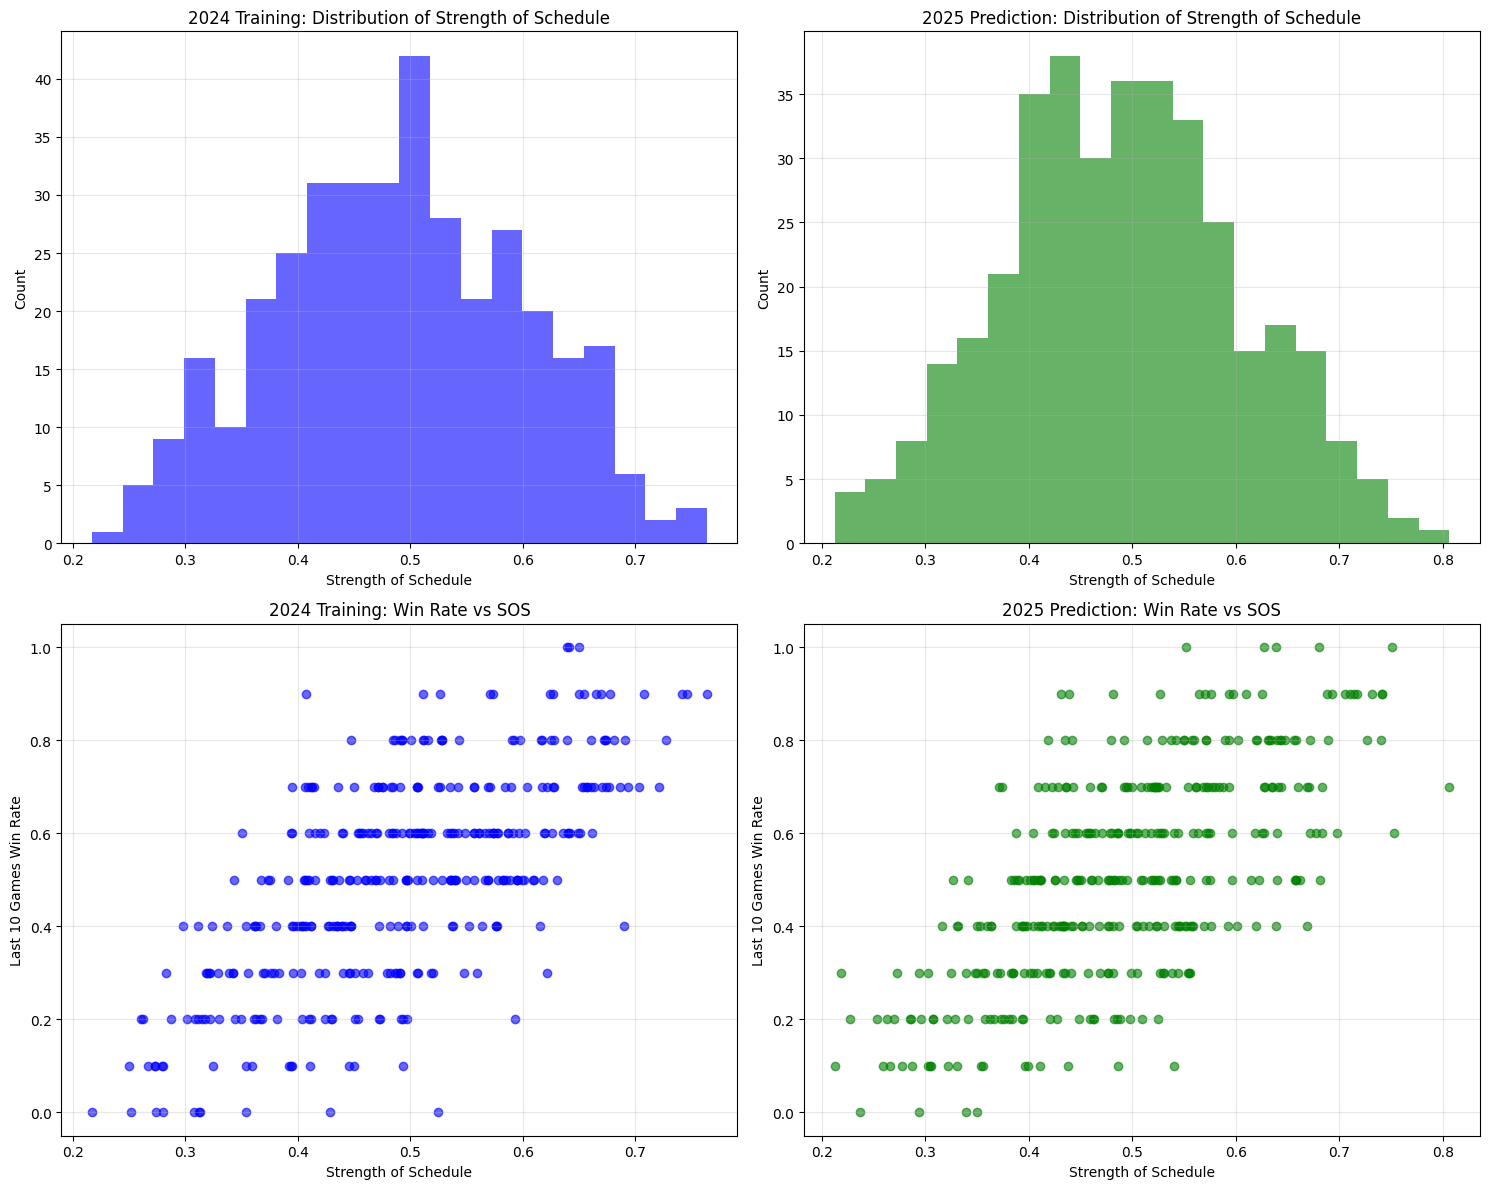


2024 Training SOS Summary:
count    362.000000
mean       0.489701
std        0.110316
min        0.216937
25%        0.410252
50%        0.490635
75%        0.572461
max        0.763431
Name: SOS, dtype: float64

2025 Prediction SOS Summary:
count    364.000000
mean       0.489999
std        0.113555
min        0.212466
25%        0.410934
50%        0.486492
75%        0.562316
max        0.806245
Name: SOS, dtype: float64

Correlation between SOS and Last10WinRate:
2024 Training: 0.6810821661221285
2025 Prediction: 0.6639142048819268


In [18]:
# Enhanced SOS calculation with day number constraint
def calculate_enhanced_sos(games_df, team_id, season, day_num=CURRENT_RANKING_DAY):
    # Filter for season and day number
    games_df = games_df[
        (games_df['Season'] == season) & 
        (games_df['DayNum'] < day_num)
    ]
    
    team_games = games_df[(games_df['WTeamID'] == team_id) | (games_df['LTeamID'] == team_id)]
    if len(team_games) == 0:
        return 0.5  # Default value for teams with no games
        
    # Calculate basic win rate against schedule
    wins = len(team_games[team_games['WTeamID'] == team_id])
    total_games = len(team_games)
    win_rate = wins / total_games
    
    # Calculate opponent strength (average win rate of opponents)
    opponent_strength = 0
    for _, game in team_games.iterrows():
        opponent_id = game['LTeamID'] if game['WTeamID'] == team_id else game['WTeamID']
        opp_games = games_df[
            ((games_df['WTeamID'] == opponent_id) | (games_df['LTeamID'] == opponent_id)) &
            (games_df['DayNum'] < game['DayNum'])  # Only consider games before this one
        ]
        if len(opp_games) > 0:
            opp_wins = len(opp_games[opp_games['WTeamID'] == opponent_id])
            opp_strength = opp_wins / len(opp_games)
            opponent_strength += opp_strength
    
    avg_opponent_strength = opponent_strength / total_games if total_games > 0 else 0.5
    
    # Combine win rate and opponent strength
    sos = (win_rate + avg_opponent_strength) / 2
    return sos

# Calculate SOS for training teams
print("Calculating SOS for 2024 training teams...")
train_team_features['SOS'] = train_team_features['TeamID'].apply(
    lambda x: calculate_enhanced_sos(games, x, TRAIN_SEASON, CURRENT_RANKING_DAY)
)

# Calculate SOS for prediction teams
print("\nCalculating SOS for 2025 prediction teams...")
predict_team_features['SOS'] = predict_team_features['TeamID'].apply(
    lambda x: calculate_enhanced_sos(games, x, PREDICT_SEASON, CURRENT_RANKING_DAY)
)

# Create visualizations
import matplotlib.pyplot as plt

# Set up the plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot SOS distributions
axes[0,0].hist(train_team_features['SOS'], bins=20, alpha=0.6, color='blue')
axes[0,0].set_title('2024 Training: Distribution of Strength of Schedule')
axes[0,0].set_xlabel('Strength of Schedule')
axes[0,0].set_ylabel('Count')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(predict_team_features['SOS'], bins=20, alpha=0.6, color='green')
axes[0,1].set_title('2025 Prediction: Distribution of Strength of Schedule')
axes[0,1].set_xlabel('Strength of Schedule')
axes[0,1].set_ylabel('Count')
axes[0,1].grid(True, alpha=0.3)

# Plot Win Rate vs SOS
axes[1,0].scatter(train_team_features['SOS'], train_team_features['Last10WinRate'], alpha=0.6, color='blue')
axes[1,0].set_title('2024 Training: Win Rate vs SOS')
axes[1,0].set_xlabel('Strength of Schedule')
axes[1,0].set_ylabel('Last 10 Games Win Rate')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].scatter(predict_team_features['SOS'], predict_team_features['Last10WinRate'], alpha=0.6, color='green')
axes[1,1].set_title('2025 Prediction: Win Rate vs SOS')
axes[1,1].set_xlabel('Strength of Schedule')
axes[1,1].set_ylabel('Last 10 Games Win Rate')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n2024 Training SOS Summary:")
print(train_team_features['SOS'].describe())
print("\n2025 Prediction SOS Summary:")
print(predict_team_features['SOS'].describe())

# Print correlation between SOS and Win Rate
print("\nCorrelation between SOS and Last10WinRate:")
print("2024 Training:", train_team_features['SOS'].corr(train_team_features['Last10WinRate']))
print("2025 Prediction:", predict_team_features['SOS'].corr(predict_team_features['Last10WinRate']))

In [22]:
# Split into train and test using CURRENT_RANKING_DAY and only 2024 season
print(f"Using 2024 games up to day {CURRENT_RANKING_DAY} for training")

# Create training data
train_games = games[
    (games["Season"] == TRAIN_SEASON) & 
    (games["DayNum"] < CURRENT_RANKING_DAY)
]
print(f"Number of training games: {len(train_games)}")

# Create test data from 2024 season after CURRENT_RANKING_DAY
raw_test_games = games[
    (games["Season"] == TRAIN_SEASON) & 
    (games["DayNum"] >= CURRENT_RANKING_DAY)
]

# Create simplified test_games with just the matchups and outcomes
test_games = []
for _, game in raw_test_games.iterrows():
    # Add the game from Team1's perspective (WTeam)
    test_games.append({
        'Team1': game['WTeamID'],
        'Team2': game['LTeamID'],
        'Outcome': 1  # Win
    })
    # Add the game from Team2's perspective (LTeam)
    test_games.append({
        'Team1': game['LTeamID'],
        'Team2': game['WTeamID'],
        'Outcome': 0  # Loss
    })

test_games = pd.DataFrame(test_games)
print(f"Number of test games: {len(test_games) // 2}")  # Divide by 2 since we have both perspectives

# Get unique teams from test games
test_teams = pd.Series(pd.concat([
    raw_test_games['WTeamID'],
    raw_test_games['LTeamID']
]).unique())

# Create test_team_features with same structure as train_team_features
test_team_features = pd.DataFrame({'TeamID': test_teams})

# Add seed information
test_team_features = test_team_features.merge(
    train_seeds[['TeamID', 'SeedValue', 'RegionName']], 
    on='TeamID', 
    how='left'
)

# Add rankings data
test_team_features = test_team_features.merge(
    train_rankings_pivot.reset_index(),
    on='TeamID',
    how='left'
)

# Calculate features for test data using the same functions as training
print("\nCalculating features for test data...")

# Calculate SOS for test teams
test_team_features['SOS'] = test_team_features['TeamID'].apply(
    lambda x: calculate_enhanced_sos(games, x, TRAIN_SEASON, CURRENT_RANKING_DAY)
)

# Calculate location-based win rates for test teams
location_performance_test = pd.DataFrame([
    calculate_location_win_rates(team_id, games, TRAIN_SEASON) 
    for team_id in test_team_features['TeamID']
])
location_performance_test['TeamID'] = test_team_features['TeamID'].values

# Add location performance to test features
test_team_features = test_team_features.merge(
    location_performance_test,
    on='TeamID',
    how='left'
)

# Ensure all columns from training data exist in test data
for col in train_team_features.columns:
    if col not in test_team_features.columns:
        print(f"Adding missing column to test data: {col}")
        test_team_features[col] = 0

# Ensure columns are in the same order
test_team_features = test_team_features[train_team_features.columns]

# Print verification information
print("\nTraining columns:", train_team_features.columns.tolist())
print("Test columns:", test_team_features.columns.tolist())

print("\nTraining team features shape:", train_team_features.shape)
print("Test team features shape:", test_team_features.shape)

print("\nSample of test games DataFrame:")
print(test_games.head())

print("\nVerify test games structure:")
print("Columns:", test_games.columns.tolist())
print("Number of unique games:", len(test_games) // 2)
print("Class distribution:")
print(test_games['Outcome'].value_counts(normalize=True))

# Verify data ranges
print("\nTraining games date range:", 
      train_games['DayNum'].min(), "to", train_games['DayNum'].max())
print("Test games date range:", 
      raw_test_games['DayNum'].min(), "to", raw_test_games['DayNum'].max())

Using 2024 games up to day 128 for training
Number of training games: 5448
Number of test games: 159

Calculating features for test data...
Adding missing column to test data: Last10WinRate

Training columns: ['TeamID', 'SeedValue', 'RegionName', 'TPR', 'MAS', 'ESR', 'POM', 'USA', 'AP', 'Last10WinRate', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate', 'SOS']
Test columns: ['TeamID', 'SeedValue', 'RegionName', 'TPR', 'MAS', 'ESR', 'POM', 'USA', 'AP', 'Last10WinRate', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate', 'SOS']

Training team features shape: (362, 14)
Test team features shape: (180, 14)

Sample of test games DataFrame:
   Team1  Team2  Outcome
0   1105   1108        1
1   1108   1105        0
2   1116   1435        1
3   1435   1116        0
4   1130   1155        1

Verify test games structure:
Columns: ['Team1', 'Team2', 'Outcome']
Number of unique games: 159
Class distribution:
Outcome
1    0.5
0    0.5
Name: proportion, dtype: float64

Training games date range: 0 to 127
Te

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler


# Print initial data shapes
print("Initial data shapes:")
print(f"train_games shape: {train_games.shape}")
print(f"train_team_features shape: {train_team_features.shape}")
print(f"test_games shape: {test_games.shape}")
print(f"test_team_features shape: {test_team_features.shape}")

def create_matchup_features(games_df, team_features_df, is_test=False):
    matchup_data = []
    processed_games = 0
    skipped_games = 0
    error_types = {}

    # Fill NaN values in team_features_df
    team_features_df = team_features_df.fillna(0)

    for _, row in games_df.iterrows():
        winner_id, loser_id = row["WTeamID"], row["LTeamID"]
        location_type = row.get('LocationType', 'N')  # Default to Neutral if not specified
        
        # Create features for both perspectives (W->L and L->W)
        for team1, team2, outcome in [(winner_id, loser_id, 1), (loser_id, winner_id, 0)]:
            # Check if both teams exist in features
            team1_data = team_features_df[team_features_df["TeamID"] == team1]
            team2_data = team_features_df[team_features_df["TeamID"] == team2]
            
            if team1_data.empty or team2_data.empty:
                skipped_games += 1
                error_msg = f"Missing team data: Team1={team1} ({'present' if not team1_data.empty else 'missing'}), Team2={team2} ({'present' if not team2_data.empty else 'missing'})"
                error_types[error_msg] = error_types.get(error_msg, 0) + 1
                continue
                
            team1_features = team1_data.iloc[0]
            team2_features = team2_data.iloc[0]
            
            try:
                # Print debug info for first few games
                if processed_games < 3:
                    print(f"\nProcessing game {processed_games + 1} (perspective {outcome}):")
                    print(f"Team1 ({team1}) features:")
                    print(team1_features[['SeedValue', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate', 'SOS']])
                    print(f"\nTeam2 ({team2}) features:")
                    print(team2_features[['SeedValue', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate', 'SOS']])
                
                features = {
                    # Seed and basic features
                    "Seed_Diff": float(team1_features["SeedValue"] - team2_features["SeedValue"]),
                    "Team1_Seed": float(team1_features["SeedValue"]),
                    "Team2_Seed": float(team2_features["SeedValue"]),
                    
                    # Raw normalized rankings for each team
                    "Team1_MAS": float(team1_features["MAS"]),
                    "Team2_MAS": float(team2_features["MAS"]),
                    "Team1_ESR": float(team1_features["ESR"]),
                    "Team2_ESR": float(team2_features["ESR"]),
                    "Team1_POM": float(team1_features["POM"]),
                    "Team2_POM": float(team2_features["POM"]),
                    
                    # Differences in rankings
                    "Ranking_Diff_MAS": float(team1_features["MAS"] - team2_features["MAS"]),
                    "Ranking_Diff_ESR": float(team1_features["ESR"] - team2_features["ESR"]),
                    "Ranking_Diff_POM": float(team1_features["POM"] - team2_features["POM"]),
                    
                    # Products of rankings
                    "Ranking_Prod_MAS": float(team1_features["MAS"] * team2_features["MAS"]),
                    "Ranking_Prod_ESR": float(team1_features["ESR"] * team2_features["ESR"]),
                    "Ranking_Prod_POM": float(team1_features["POM"] * team2_features["POM"]),
                    
                    # Win rates
                    "Last10WinRate_Team1": float(team1_features["Last10WinRate"]),
                    "Last10WinRate_Team2": float(team2_features["Last10WinRate"]),
                    "WinRate_Diff": float(team1_features["Last10WinRate"] - team2_features["Last10WinRate"]),
                    
                    # Location-specific win rates
                    'HomeWinRate_Team1': float(team1_features["HomeWinRate"]),
                    'HomeWinRate_Team2': float(team2_features["HomeWinRate"]),
                    'AwayWinRate_Team1': float(team1_features["AwayWinRate"]),
                    'AwayWinRate_Team2': float(team2_features["AwayWinRate"]),
                    'NeutralWinRate_Team1': float(team1_features["NeutralWinRate"]),
                    'NeutralWinRate_Team2': float(team2_features["NeutralWinRate"]),
                    
                    # SOS features
                    'SOS_Team1': float(team1_features["SOS"]),
                    'SOS_Team2': float(team2_features["SOS"]),
                    'SOS_Diff': float(team1_features["SOS"] - team2_features["SOS"]),
                    
                    # Location type indicators
                    'IsHome': 1 if location_type == 'H' else 0,
                    'IsAway': 1 if location_type == 'A' else 0,
                    'IsNeutral': 1 if location_type == 'N' else 0,
                    
                    # Location advantage metrics
                    'HomeAway_Advantage': float(team1_features["HomeWinRate"] - team2_features["AwayWinRate"]),
                    'Neutral_Advantage': float(team1_features["NeutralWinRate"] - team2_features["NeutralWinRate"]),
                    
                    "Outcome": outcome
                }
                
                # Add squared differences
                features.update({
                    "Ranking_Diff_MAS_Squared": features["Ranking_Diff_MAS"] ** 2,
                    "Ranking_Diff_ESR_Squared": features["Ranking_Diff_ESR"] ** 2,
                    "Ranking_Diff_POM_Squared": features["Ranking_Diff_POM"] ** 2,
                    "Seed_Diff_Squared": features["Seed_Diff"] ** 2,
                    "WinRate_Diff_Squared": features["WinRate_Diff"] ** 2,
                    "SOS_Diff_Squared": features["SOS_Diff"] ** 2,
                })
                
                matchup_data.append(features)
                
            except Exception as e:
                error_msg = str(e)
                error_types[error_msg] = error_types.get(error_msg, 0) + 1
                if processed_games < 5:
                    print(f"\nError processing game: Team1={team1}, Team2={team2}")
                    print(f"Error: {error_msg}")
                continue
            
        processed_games += 1

    print(f"\nProcessed {processed_games} games successfully")
    print(f"Skipped {skipped_games} games due to missing team data")

    if error_types:
        print("\nError type summary:")
        for error_msg, count in error_types.items():
            print(f"{error_msg}: {count} occurrences")

    return pd.DataFrame(matchup_data) if matchup_data else None

# Create features for training and test sets
print("\nCreating training matchup features...")
df_train = create_matchup_features(train_games, train_team_features)

print("\nCreating test matchup features...")
df_test = create_matchup_features(test_games, test_team_features)

# Print class distribution before modeling
print("\nInitial class distribution:")
print("Training outcomes:", df_train['Outcome'].value_counts(normalize=True))
print("Test outcomes:", df_test['Outcome'].value_counts(normalize=True))

if df_train is not None and df_test is not None:
    # Handle any remaining NaN values using imputer
    imputer = SimpleImputer(strategy='mean')
    
    # Separate features and target
    X_train = df_train.drop('Outcome', axis=1)
    y_train = df_train['Outcome']
    X_test = df_test.drop('Outcome', axis=1)
    y_test = df_test['Outcome']
    
    # Impute missing values
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    
    # Add scaling here
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    # Print data shapes and class distribution
    print("\nData Shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    
    print("\nClass Distribution after preprocessing:")
    print("Training:", pd.Series(y_train).value_counts(normalize=True))
    print("Test:", pd.Series(y_test).value_counts(normalize=True))
    
    # Only proceed if we have both classes
    if len(np.unique(y_train)) < 2:
        print("\nERROR: Training data contains only one class!")
        print("Please check how the Outcome variable is being created.")
    else:
        # Define stratified cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Train and evaluate models
        print("\n=== Model Training and Evaluation ===")
        
        # Logistic Regression
        print("\nTraining Logistic Regression...")
        lr_model = LogisticRegression(random_state=42)
        lr_scores = cross_val_score(lr_model, X_train, y_train, cv=skf)
        print(f"CV Scores: {lr_scores}")
        print(f"Average CV Score: {lr_scores.mean():.3f} (+/- {lr_scores.std() * 2:.3f})")
        
        # Gradient Boosting
        print("\nTraining Gradient Boosting...")
        gb_model = GradientBoostingClassifier(random_state=42)
        gb_scores = cross_val_score(gb_model, X_train, y_train, cv=skf)
        print(f"CV Scores: {gb_scores}")
        print(f"Average CV Score: {gb_scores.mean():.3f} (+/- {gb_scores.std() * 2:.3f})")
        
        # Train final models on full training data
        lr_model.fit(X_train, y_train)
        gb_model.fit(X_train, y_train)
        
        # Print feature importance
        lr_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': np.abs(lr_model.coef_[0])
        }).sort_values('Importance', ascending=False)
        
        gb_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': gb_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 Most Important Features (Logistic Regression):")
        print(lr_importance.head(10))
        
        print("\nTop 10 Most Important Features (Gradient Boosting):")
        print(gb_importance.head(10))
else:
    print("\nERROR: Failed to create features!")

Initial data shapes:
train_games shape: (5448, 8)
train_team_features shape: (362, 14)
test_games shape: (159, 8)
test_team_features shape: (180, 14)

Creating training matchup features...

Processing game 1 (perspective 1):
Team1 (1101) features:
SeedValue              0.0
HomeWinRate         0.4375
AwayWinRate       0.454545
NeutralWinRate    0.666667
SOS               0.474915
Name: 25, dtype: object

Team2 (1329) features:
SeedValue              0.0
HomeWinRate       0.526316
AwayWinRate       0.111111
NeutralWinRate        0.25
SOS               0.472494
Name: 223, dtype: object

Processing game 1 (perspective 0):
Team1 (1329) features:
SeedValue              0.0
HomeWinRate       0.526316
AwayWinRate       0.111111
NeutralWinRate        0.25
SOS               0.472494
Name: 223, dtype: object

Team2 (1101) features:
SeedValue              0.0
HomeWinRate         0.4375
AwayWinRate       0.454545
NeutralWinRate    0.666667
SOS               0.474915
Name: 25, dtype: object

Proces

In [23]:
# Analyze and make predictions on test data
print("=== Test Data Analysis and Predictions ===")

# Verify test data is properly processed
print("\nTest data shape:", X_test.shape)
print("Number of test samples:", len(X_test))

# Make predictions using LR model
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)

# Create initial results DataFrame with predictions
test_results = pd.DataFrame({
    'Team1': test_games['Team1'],
    'Team2': test_games['Team2'],
    'True_Outcome': y_test,
    'LR_Prediction': lr_predictions,
    'LR_Win_Probability': lr_probabilities[:, 1]
})

# Compare with raw_test_games
verified_results = []
for idx, pred_row in test_results.iterrows():
    team1, team2 = pred_row['Team1'], pred_row['Team2']
    
    # Look for this matchup in raw_test_games
    actual_game = raw_test_games[
        ((raw_test_games['WTeamID'] == team1) & (raw_test_games['LTeamID'] == team2)) |
        ((raw_test_games['WTeamID'] == team2) & (raw_test_games['LTeamID'] == team1))
    ]
    
    if len(actual_game) > 0:
        # Found the matchup
        actual_game = actual_game.iloc[0]
        
        # Determine if prediction was correct
        if actual_game['WTeamID'] == team1:
            correct_prediction = (pred_row['LR_Prediction'] == 1)
            actual_outcome = 1
        else:
            correct_prediction = (pred_row['LR_Prediction'] == 0)
            actual_outcome = 0
            
        verified_results.append({
            'Team1': team1,
            'Team2': team2,
            'Predicted_Winner': team1 if pred_row['LR_Prediction'] == 1 else team2,
            'Actual_Winner': actual_game['WTeamID'],
            'Predicted_Outcome': pred_row['LR_Prediction'],
            'Actual_Outcome': actual_outcome,
            'Win_Probability': pred_row['LR_Win_Probability'],
            'Is_Correct': correct_prediction,
            'Game_Day': actual_game['DayNum']
        })

verified_results = pd.DataFrame(verified_results)

# Print performance metrics
print("\nModel Performance on Test Games:")
print(f"Total Games Analyzed: {len(verified_results)}")
print(f"Correct Predictions: {verified_results['Is_Correct'].sum()}")
print(f"Accuracy: {(verified_results['Is_Correct'].mean() * 100):.2f}%")

# Analyze prediction confidence
print("\nPrediction Confidence Analysis:")
print("Win probability distribution:")
print(verified_results['Win_Probability'].describe().round(3))

# Look at most confident correct predictions
print("\nMost confident correct predictions:")
confident_correct = verified_results[
    verified_results['Is_Correct']
].nlargest(10, 'Win_Probability')
print("\nTop 10 most confident correct predictions:")
for _, row in confident_correct.iterrows():
    print(f"Team {row['Team1']} vs Team {row['Team2']}: "
          f"Predicted {row['Predicted_Winner']} would win with {row['Win_Probability']:.3f} probability "
          f"(Actual winner: {row['Actual_Winner']})")

# Look at incorrect predictions
incorrect_predictions = verified_results[~verified_results['Is_Correct']]
print(f"\nNumber of incorrect predictions: {len(incorrect_predictions)}")
print("\nMost confident incorrect predictions:")
confident_incorrect = incorrect_predictions.nlargest(10, 'Win_Probability')
for _, row in confident_incorrect.iterrows():
    print(f"Team {row['Team1']} vs Team {row['Team2']}: "
          f"Predicted {row['Predicted_Winner']} would win with {row['Win_Probability']:.3f} probability "
          f"but {row['Actual_Winner']} won")

# Analyze performance by confidence level
print("\nAccuracy by confidence level:")
confidence_bins = pd.qcut(verified_results['Win_Probability'], q=5)
accuracy_by_confidence = verified_results.groupby(confidence_bins)['Is_Correct'].agg(['count', 'mean'])
print(accuracy_by_confidence.round(3))

# Save verified results
verified_results.to_csv('verified_test_predictions.csv', index=False)
print("\nVerified predictions saved to 'verified_test_predictions.csv'")

# Analyze performance by game day
print("\nAccuracy by game day:")
accuracy_by_day = verified_results.groupby('Game_Day')['Is_Correct'].agg(['count', 'mean'])
print(accuracy_by_day.round(3))

=== Test Data Analysis and Predictions ===

Test data shape: (318, 38)
Number of test samples: 318

Model Performance on Test Games:
Total Games Analyzed: 318
Correct Predictions: 192
Accuracy: 60.38%

Prediction Confidence Analysis:
Win probability distribution:
count    318.000
mean       0.499
std        0.242
min        0.030
25%        0.296
50%        0.501
75%        0.702
max        0.970
Name: Win_Probability, dtype: float64

Most confident correct predictions:

Top 10 most confident correct predictions:
Team 1429.0 vs Team 1201.0: Predicted 1429.0 would win with 0.970 probability (Actual winner: 1429)
Team 1313.0 vs Team 1164.0: Predicted 1313.0 would win with 0.966 probability (Actual winner: 1313)
Team 1307.0 vs Team 1102.0: Predicted 1307.0 would win with 0.959 probability (Actual winner: 1307)
Team 1161.0 vs Team 1363.0: Predicted 1161.0 would win with 0.951 probability (Actual winner: 1161)
Team 1437.0 vs Team 1177.0: Predicted 1437.0 would win with 0.947 probability (Ac

/var/folders/gc/_00hl__j42163556kvkzz4b40000gq/T/ipykernel_45653/912534056.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_confidence = verified_results.groupby(confidence_bins)['Is_Correct'].agg(['count', 'mean'])


In [25]:
# Reassess feature importance based on prediction results
print("=== Feature Importance Reassessment ===")

# Get feature importance from the logistic regression model
if 'lr_model' in locals():
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(lr_model.coef_[0])
    }).sort_values('Importance', ascending=False)
    
    FEATURE_IMPORTANCE = dict(zip(feature_importance['Feature'], feature_importance['Importance']))
    IMPORTANT_FEATURES = feature_importance['Feature'].tolist()

    # Print original feature importance
    print("\nOriginal Top Features:")
    for feature, importance in FEATURE_IMPORTANCE.items():
        print(f"{feature:<30} {importance:.6f}")

    # Analyze feature importance for correct vs incorrect predictions
    correct_mask = verified_results['Is_Correct']

    # Create feature comparison DataFrame
    feature_analysis = pd.DataFrame({
        'Correct_Pred_Avg': X_test[correct_mask].mean(),
        'Incorrect_Pred_Avg': X_test[~correct_mask].mean(),
        'Correct_Pred_Std': X_test[correct_mask].std(),
        'Incorrect_Pred_Std': X_test[~correct_mask].std(),
        'Original_Importance': pd.Series(FEATURE_IMPORTANCE)
    })

    # Calculate absolute difference between correct and incorrect predictions
    feature_analysis['Predictive_Power'] = abs(
        feature_analysis['Correct_Pred_Avg'] - feature_analysis['Incorrect_Pred_Avg']
    )

    # Calculate signal-to-noise ratio (mean difference / pooled standard deviation)
    feature_analysis['Signal_to_Noise'] = abs(
        feature_analysis['Correct_Pred_Avg'] - feature_analysis['Incorrect_Pred_Avg']
    ) / np.sqrt((feature_analysis['Correct_Pred_Std']**2 + feature_analysis['Incorrect_Pred_Std']**2) / 2)

    # Sort by different metrics
    print("\nTop Features by Predictive Power (Absolute Difference):")
    predictive_power = feature_analysis.sort_values('Predictive_Power', ascending=False)
    for idx, (feature, row) in enumerate(predictive_power.iterrows(), 1):
        print(f"{idx}. {feature:<30} "
              f"Diff: {row['Predictive_Power']:.6f} "
              f"(Original Rank: {IMPORTANT_FEATURES.index(feature) + 1})")

    print("\nTop Features by Signal-to-Noise Ratio:")
    signal_to_noise = feature_analysis.sort_values('Signal_to_Noise', ascending=False)
    for idx, (feature, row) in enumerate(signal_to_noise.iterrows(), 1):
        print(f"{idx}. {feature:<30} "
              f"S/N: {row['Signal_to_Noise']:.6f} "
              f"(Original Rank: {IMPORTANT_FEATURES.index(feature) + 1})")

    # Analyze feature correlation with prediction success
    print("\nFeature Correlation with Prediction Success:")
    feature_success_corr = pd.DataFrame()
    for feature in X_test.columns:
        success_corr = X_test[feature].corr(verified_results['Is_Correct'])
        feature_success_corr.loc[feature, 'Correlation'] = success_corr

    # Sort by absolute correlation
    feature_success_corr['Abs_Correlation'] = feature_success_corr['Correlation'].abs()
    feature_success_corr = feature_success_corr.sort_values('Abs_Correlation', ascending=False)

    print("\nTop Features by Correlation with Prediction Success:")
    for idx, (feature, row) in enumerate(feature_success_corr.iterrows(), 1):
        print(f"{idx}. {feature:<30} "
              f"Corr: {row['Correlation']:.6f} "
              f"(Original Rank: {IMPORTANT_FEATURES.index(feature) + 1})")

    # Create recommendations for feature selection
    print("\nFeature Selection Recommendations:")
    recommended_features = set()

    # Add top features from each metric
    for feature_list in [
        predictive_power.head(5).index,
        signal_to_noise.head(5).index,
        feature_success_corr.head(5).index
    ]:
        recommended_features.update(feature_list)

    print("\nRecommended Features for Future Predictions:")
    for idx, feature in enumerate(recommended_features, 1):
        metrics = {
            'Predictive Power': predictive_power.index.get_loc(feature) + 1,
            'Signal-to-Noise': signal_to_noise.index.get_loc(feature) + 1,
            'Success Correlation': feature_success_corr.index.get_loc(feature) + 1,
            'Original Rank': IMPORTANT_FEATURES.index(feature) + 1
        }
        print(f"{idx}. {feature:<30}")
        print(f"   Rankings - Original: {metrics['Original Rank']}, "
              f"Predictive Power: {metrics['Predictive Power']}, "
              f"S/N: {metrics['Signal-to-Noise']}, "
              f"Success Correlation: {metrics['Success Correlation']}")

    # Save analysis results
    feature_analysis.to_csv('feature_importance_analysis.csv')
    print("\nDetailed feature analysis saved to 'feature_importance_analysis.csv'")
else:
    print("Error: Logistic Regression model not found. Please run model training first.")

=== Feature Importance Reassessment ===

Original Top Features:
SOS_Diff                       1.034827
SOS_Team1                      0.642026
SOS_Team2                      0.629952
HomeWinRate_Team2              0.167790
HomeWinRate_Team1              0.165724
AwayWinRate_Team1              0.159881
AwayWinRate_Team2              0.146678
WinRate_Diff                   0.084157
Last10WinRate_Team2            0.061225
Last10WinRate_Team1            0.059888
Ranking_Diff_ESR               0.017640
HomeAway_Advantage             0.013380
Team2_ESR                      0.012741
Team1_ESR                      0.012485
Ranking_Diff_MAS               0.011332
Ranking_Diff_POM               0.009775
Team2_MAS                      0.008455
Team1_MAS                      0.007768
Team2_POM                      0.007125
Team1_POM                      0.006514
Team1_Seed                     0.006405
Seed_Diff                      0.005807
Neutral_Advantage              0.004552
NeutralWinRate_T

/Users/erinyepis/opt/anaconda3/envs/dbt-local-env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/erinyepis/opt/anaconda3/envs/dbt-local-env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/erinyepis/opt/anaconda3/envs/dbt-local-env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/erinyepis/opt/anaconda3/envs/dbt-local-env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/erinyepis/opt/anaconda3/envs/dbt-local-env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/erinyepis/opt/anaconda3/envs

In [28]:
# Get top 10 from original feature importance
original_top_10 = feature_importance.head(10)['Feature'].tolist()
print("\nOriginal Top 10 Features:")
for idx, feature in enumerate(original_top_10, 1):
    print(f"{idx}. {feature:<30} {FEATURE_IMPORTANCE[feature]:.6f}")

# Get top 10 recommended features by combining rankings
recommended_features = []
for feature in X_test.columns:
    pp_rank = predictive_power.index.get_loc(feature) + 1
    sn_rank = signal_to_noise.index.get_loc(feature) + 1
    corr_rank = feature_success_corr.index.get_loc(feature) + 1
    avg_rank = (pp_rank + sn_rank + corr_rank) / 3
    recommended_features.append({
        'Feature': feature,
        'Average_Rank': avg_rank,
        'PP_Rank': pp_rank,
        'SN_Rank': sn_rank,
        'Corr_Rank': corr_rank
    })

recommended_df = pd.DataFrame(recommended_features)
recommended_top_10 = recommended_df.nsmallest(10, 'Average_Rank')['Feature'].tolist()

print("\nRecommended Top 10 Features:")
for idx, feature in enumerate(recommended_top_10, 1):
    feature_data = recommended_df[recommended_df['Feature'] == feature].iloc[0]
    print(f"{idx}. {feature:<30} "
          f"(Avg Rank: {feature_data['Average_Rank']:.2f}, "
          f"PP Rank: {feature_data['PP_Rank']}, "
          f"S/N Rank: {feature_data['SN_Rank']}, "
          f"Corr Rank: {feature_data['Corr_Rank']})")

# Combine both lists and remove duplicates while preserving order
FINAL_FEATURES = []
for feature in original_top_10 + recommended_top_10:
    if feature not in FINAL_FEATURES:
        FINAL_FEATURES.append(feature)

print("\nFinal Combined Feature List (duplicates removed):")
print(f"Total Features: {len(FINAL_FEATURES)}")
for idx, feature in enumerate(FINAL_FEATURES, 1):
    if feature in original_top_10:
        source = "Original"
        importance = FEATURE_IMPORTANCE[feature]
        print(f"{idx}. {feature:<30} {importance:.6f} (Source: {source})")
    else:
        source = "Recommended"
        feature_data = recommended_df[recommended_df['Feature'] == feature].iloc[0]
        print(f"{idx}. {feature:<30} (Source: {source}, "
              f"Avg Rank: {feature_data['Average_Rank']:.2f}, "
              f"PP Rank: {feature_data['PP_Rank']}, "
              f"S/N Rank: {feature_data['SN_Rank']}, "
              f"Corr Rank: {feature_data['Corr_Rank']})")

# Save the final feature list
np.save('final_features.npy', FINAL_FEATURES)
print("\nFinal features saved to 'final_features.npy'")


Original Top 10 Features:
1. SOS_Diff                       1.034827
2. SOS_Team1                      0.642026
3. SOS_Team2                      0.629952
4. HomeWinRate_Team2              0.167790
5. HomeWinRate_Team1              0.165724
6. AwayWinRate_Team1              0.159881
7. AwayWinRate_Team2              0.146678
8. WinRate_Diff                   0.084157
9. Last10WinRate_Team2            0.061225
10. Last10WinRate_Team1            0.059888

Recommended Top 10 Features:
1. Ranking_Diff_ESR_Squared       (Avg Rank: 2.67, PP Rank: 1, S/N Rank: 5, Corr Rank: 2)
2. AwayWinRate_Team1              (Avg Rank: 5.00, PP Rank: 3, S/N Rank: 7, Corr Rank: 5)
3. SOS_Diff_Squared               (Avg Rank: 5.00, PP Rank: 10, S/N Rank: 4, Corr Rank: 1)
4. AwayWinRate_Team2              (Avg Rank: 5.33, PP Rank: 4, S/N Rank: 8, Corr Rank: 4)
5. Ranking_Prod_MAS               (Avg Rank: 6.67, PP Rank: 11, S/N Rank: 6, Corr Rank: 3)
6. Ranking_Prod_ESR               (Avg Rank: 7.33, PP Rank: 

In [ ]:
##START HERE 3-19 NEED to CREATE prediction matchups with features from above
# # Create a more readable matchup display
print("Sample of Training Matchups with Features:")

# Get top features from logistic regression model
if 'lr_importance' in locals():
    # Get top features and add squared differences
    top_features = lr_importance.head(10)['Feature'].tolist()
    important_squared_features = ['Ranking_Diff_ESR_Squared', 'Seed_Diff_Squared']
    
    # Add squared features if not already in top features
    for feature in important_squared_features:
        if feature not in top_features:
            top_features.append(feature)
    
    # Create feature importance dictionary
    feature_importance_dict = dict(zip(
        lr_importance['Feature'],
        lr_importance['Importance']
    ))
    
    # Add importance scores for squared features if not in top 10
    for feature in important_squared_features:
        if feature not in feature_importance_dict:
            feature_importance_dict[feature] = lr_importance[
                lr_importance['Feature'] == feature
            ]['Importance'].values[0]
    
    display_columns = ['Outcome'] + top_features
    
    print("\nUpdated Important Features and their Importance Scores:")
    for feature in top_features:
        print(f"{feature:<30} {feature_importance_dict[feature]:.6f}")
else:
    # Fallback to original display columns if lr_importance not available
    display_columns = [
        'Outcome',
        'Seed_Diff', 'SOS_Diff',
        'WinRate_Diff',
        'Team1_Seed', 'Team2_Seed',
        'Last10WinRate_Team1', 'Last10WinRate_Team2',
        'SOS_Team1', 'SOS_Team2',
        'Team1_MAS', 'Team2_MAS',
        'Team1_ESR', 'Team2_ESR',
        'Team1_POM', 'Team2_POM',
        'IsHome', 'IsAway', 'IsNeutral',
        'HomeWinRate_Team1', 'AwayWinRate_Team2',
        'HomeAway_Advantage',
        'Ranking_Diff_ESR_Squared', 'Seed_Diff_Squared'
    ]

# Save important features for later use
IMPORTANT_FEATURES = top_features
FEATURE_IMPORTANCE = feature_importance_dict

# Display matchups and features
if 'df_train' in locals() and 'train_games' in locals():
    # First verify what columns we actually have
    print("\nAvailable columns in df_train:")
    print(df_train.columns.tolist())
    
    # Create a sample display with team information
    matchups_display = df_train[display_columns].head(25).copy()
    
    # Add team information
    team_info = []
    for idx, row in matchups_display.iterrows():
        if row['Outcome'] == 1:
            team1_id = train_games.iloc[idx//2]['WTeamID']
            team2_id = train_games.iloc[idx//2]['LTeamID']
        else:
            team1_id = train_games.iloc[idx//2]['LTeamID']
            team2_id = train_games.iloc[idx//2]['WTeamID']
        team_info.append({'Team1ID': team1_id, 'Team2ID': team2_id})
    
    team_df = pd.DataFrame(team_info)
    matchups_display = pd.concat([team_df, matchups_display], axis=1)
    
    # Round floating point numbers for better display
    float_cols = matchups_display.select_dtypes(include=['float64']).columns
    matchups_display[float_cols] = matchups_display[float_cols].round(3)
    
    print("\nShape of training data:", df_train.shape)
    print("\nFeature summary (with team IDs):")
    print(matchups_display)
    
    # Print some basic statistics (excluding team IDs)
    print("\nAverage feature values for wins vs losses:")
    avg_by_outcome = df_train[display_columns].groupby('Outcome').mean().round(3)
    print(avg_by_outcome)
    
    # Print feature differences between wins and losses
    print("\nFeature differences (Win - Loss):")
    feature_diffs = (avg_by_outcome.loc[1] - avg_by_outcome.loc[0]).round(3)
    print(feature_diffs)
else:
    print("No training data available yet. Please run the feature creation cell first.")

Sample of Training Matchups with Features:


NameError: name 'top_features' is not defined

In [34]:
# Create prediction matchups using important features
print("Creating 2025 prediction matchups...")

if 'IMPORTANT_FEATURES' not in locals():
    print("Error: Important features not found. Please run the feature importance analysis first.")
else:
    # Create all possible matchups between 2025 teams
    prediction_matchups = []
    for i, team1 in prediction_teams.iterrows():
        for j, team2 in prediction_teams.iterrows():
            if i < j:  # Avoid duplicate matchups
                try:
                    matchup = {
                        'Team1ID': team1['TeamID'],
                        'Team2ID': team2['TeamID']
                    }
                    
                    # Add only the important features we identified
                    for feature in IMPORTANT_FEATURES:
                        if '_Team1' in feature:
                            base_feature = feature.replace('_Team1', '')
                            matchup[feature] = team1[base_feature]
                        elif '_Team2' in feature:
                            base_feature = feature.replace('_Team2', '')
                            matchup[feature] = team2[base_feature]
                        elif '_Diff' in feature:
                            if '_Squared' in feature:
                                base_feature = feature.replace('_Diff_Squared', '')
                                diff = team1[base_feature] - team2[base_feature]
                                matchup[feature] = diff ** 2
                            else:
                                base_feature = feature.replace('_Diff', '')
                                matchup[feature] = team1[base_feature] - team2[base_feature]
                        elif feature == 'HomeAway_Advantage':
                            matchup[feature] = team1['HomeWinRate'] - team2['AwayWinRate']
                    
                    prediction_matchups.append(matchup)
                    
                except Exception as e:
                    print(f"Error processing matchup {i} vs {j}:")
                    print(f"Error: {str(e)}")
                    continue

    # Create DataFrame with important features
    df_2025_train = pd.DataFrame(prediction_matchups)
    
    # Print summary
    print("\nPrediction Data Summary:")
    print(f"Total possible matchups: {len(df_2025_train)}")
    
    # Display sample matchups
    print("\nSample of prediction matchups (first 5 rows):")
    display_columns = ['Team1ID', 'Team2ID'] + IMPORTANT_FEATURES
    sample_display = df_2025_train[display_columns].head()
    
    # Round floating point numbers
    float_cols = sample_display.select_dtypes(include=['float64']).columns
    sample_display[float_cols] = sample_display[float_cols].round(3)
    print(sample_display)
    
    # Print feature statistics
    print("\nFeature statistics for prediction matchups:")
    stats_display = df_2025_train[IMPORTANT_FEATURES].describe().round(3)
    print(stats_display)
    
    print("\nFeatures included:")
    for idx, feature in enumerate(IMPORTANT_FEATURES, 1):
        print(f"{idx}. {feature:<30} {FEATURE_IMPORTANCE[feature]:.6f}")

Creating 2025 prediction matchups...
Error processing matchup 0 vs 1:
Error: 'WinRate'
Error processing matchup 0 vs 2:
Error: 'WinRate'
Error processing matchup 0 vs 3:
Error: 'WinRate'
Error processing matchup 0 vs 4:
Error: 'WinRate'
Error processing matchup 0 vs 5:
Error: 'WinRate'
Error processing matchup 0 vs 6:
Error: 'WinRate'
Error processing matchup 0 vs 7:
Error: 'WinRate'
Error processing matchup 0 vs 8:
Error: 'WinRate'
Error processing matchup 0 vs 9:
Error: 'WinRate'
Error processing matchup 0 vs 10:
Error: 'WinRate'
Error processing matchup 0 vs 11:
Error: 'WinRate'
Error processing matchup 0 vs 12:
Error: 'WinRate'
Error processing matchup 0 vs 13:
Error: 'WinRate'
Error processing matchup 0 vs 14:
Error: 'WinRate'
Error processing matchup 0 vs 15:
Error: 'WinRate'
Error processing matchup 0 vs 16:
Error: 'WinRate'
Error processing matchup 0 vs 17:
Error: 'WinRate'
Error processing matchup 0 vs 18:
Error: 'WinRate'
Error processing matchup 0 vs 19:
Error: 'WinRate'
Err

KeyError: "None of [Index(['Team1ID', 'Team2ID', 'SOS_Diff', 'SOS_Team1', 'SOS_Team2',\n       'HomeWinRate_Team2', 'HomeWinRate_Team1', 'AwayWinRate_Team1',\n       'AwayWinRate_Team2', 'WinRate_Diff', 'Last10WinRate_Team2',\n       'Last10WinRate_Team1', 'Ranking_Diff_ESR_Squared', 'Seed_Diff_Squared'],\n      dtype='object')] are in the [columns]"

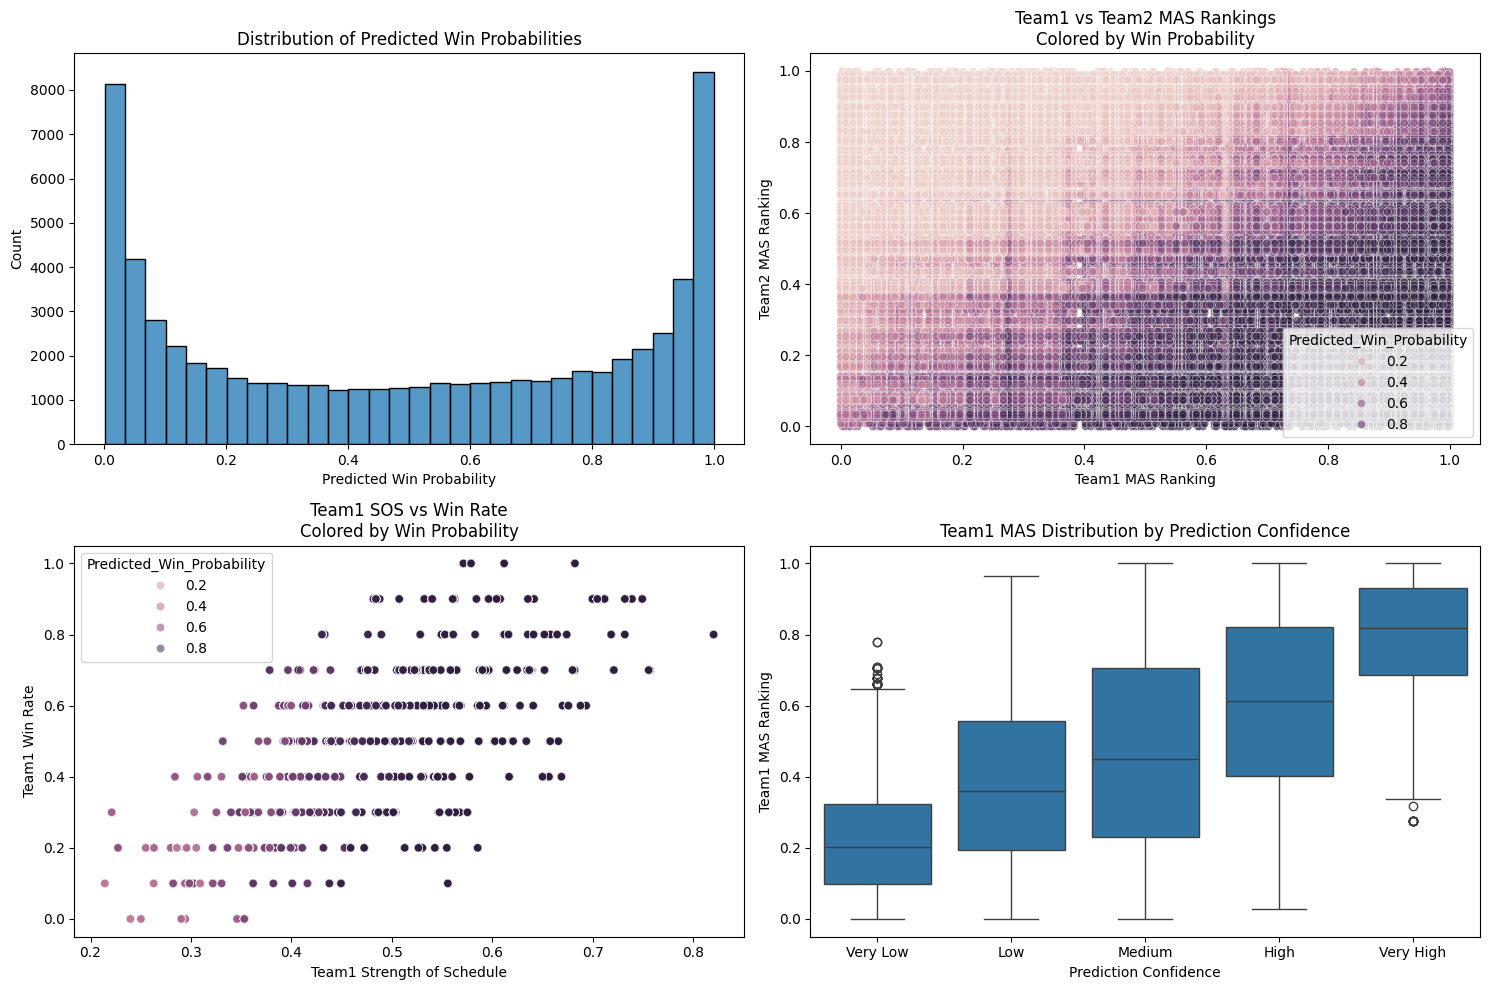


Prediction Analysis by Team Strength:

Stats by Prediction Confidence Level:
                      Team1_MAS        Team2_MAS        Team1_SOS         \
                           mean    std      mean    std      mean    std   
Prediction_Confidence                                                      
Very Low                  0.221  0.152     0.793  0.140     0.386  0.071   
Low                       0.382  0.227     0.621  0.212     0.445  0.087   
Medium                    0.472  0.276     0.485  0.269     0.481  0.104   
High                      0.604  0.248     0.394  0.248     0.532  0.098   
Very High                 0.796  0.155     0.233  0.169     0.607  0.080   

                      Team2_SOS        Team1_WinRate         
                           mean    std          mean    std  
Prediction_Confidence                                        
Very Low                  0.600  0.071         0.375  0.204  
Low                       0.533  0.085         0.462  0.219  
Med

/var/folders/gc/_00hl__j42163556kvkzz4b40000gq/T/ipykernel_58674/2959814057.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confidence_stats = analysis_df.groupby('Prediction_Confidence').agg({


In [108]:
# Analyze prediction patterns
import seaborn as sns
import matplotlib.pyplot as plt

# Create analysis DataFrame
analysis_df = results.copy()

# Add team ranking information
team_rankings = prediction_teams[['MAS', 'ESR', 'POM', 'SOS', 'Last10WinRate']]
analysis_df['Team1_MAS'] = analysis_df['Team1'].map(team_rankings['MAS'])
analysis_df['Team2_MAS'] = analysis_df['Team2'].map(team_rankings['MAS'])
analysis_df['Team1_SOS'] = analysis_df['Team1'].map(team_rankings['SOS'])
analysis_df['Team2_SOS'] = analysis_df['Team2'].map(team_rankings['SOS'])
analysis_df['Team1_WinRate'] = analysis_df['Team1'].map(team_rankings['Last10WinRate'])
analysis_df['Team2_WinRate'] = analysis_df['Team2'].map(team_rankings['Last10WinRate'])

# Create visualizations
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(data=analysis_df, x='Predicted_Win_Probability', bins=30)
plt.title('Distribution of Predicted Win Probabilities')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
sns.scatterplot(data=analysis_df, 
                x='Team1_MAS', 
                y='Team2_MAS', 
                hue='Predicted_Win_Probability',
                alpha=0.6)
plt.title('Team1 vs Team2 MAS Rankings\nColored by Win Probability')
plt.xlabel('Team1 MAS Ranking')
plt.ylabel('Team2 MAS Ranking')

plt.subplot(2, 2, 3)
sns.scatterplot(data=analysis_df,
                x='Team1_SOS',
                y='Team1_WinRate',
                hue='Predicted_Win_Probability',
                alpha=0.6)
plt.title('Team1 SOS vs Win Rate\nColored by Win Probability')
plt.xlabel('Team1 Strength of Schedule')
plt.ylabel('Team1 Win Rate')

plt.subplot(2, 2, 4)
sns.boxplot(data=analysis_df,
            x=pd.qcut(analysis_df['Predicted_Win_Probability'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']),
            y='Team1_MAS')
plt.title('Team1 MAS Distribution by Prediction Confidence')
plt.xlabel('Prediction Confidence')
plt.ylabel('Team1 MAS Ranking')

plt.tight_layout()
plt.show()

# Print statistical analysis
print("\nPrediction Analysis by Team Strength:")
analysis_df['Prediction_Confidence'] = pd.qcut(analysis_df['Predicted_Win_Probability'], 
                                             q=5, 
                                             labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

confidence_stats = analysis_df.groupby('Prediction_Confidence').agg({
    'Team1_MAS': ['mean', 'std'],
    'Team2_MAS': ['mean', 'std'],
    'Team1_SOS': ['mean', 'std'],
    'Team2_SOS': ['mean', 'std'],
    'Team1_WinRate': ['mean', 'std']
}).round(3)

print("\nStats by Prediction Confidence Level:")
print(confidence_stats)

# Find most lopsided predicted matchups
print("\nMost Lopsided Predicted Matchups:")
lopsided_matchups = analysis_df.nlargest(10, 'Predicted_Win_Probability')[
    ['Team1', 'Team2', 'Predicted_Win_Probability', 'Team1_MAS', 'Team2_MAS']
].round(3)
print(lopsided_matchups)

# Find closest predicted matchups
print("\nClosest Predicted Matchups:")
close_matchups = analysis_df.iloc[(analysis_df['Predicted_Win_Probability'] - 0.5).abs().argsort()[:10]][
    ['Team1', 'Team2', 'Predicted_Win_Probability', 'Team1_MAS', 'Team2_MAS']
].round(3)
print(close_matchups)

# Calculate correlation matrix
print("\nFeature Correlations with Predicted Win Probability:")
correlation_features = ['Predicted_Win_Probability', 'Team1_MAS', 'Team2_MAS', 
                       'Team1_SOS', 'Team2_SOS', 'Team1_WinRate', 'Team2_WinRate']
correlations = analysis_df[correlation_features].corr()['Predicted_Win_Probability'].sort_values(ascending=False)
print(correlations.round(3))

In [1]:
# Add necessary imports
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Model Performance Evaluation")
print("-" * 50)

# Create and train the main model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Perform k-fold cross validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
cv_scores = {
    'accuracy': [],
    'log_loss': [],
    'roc_auc': [],
    'precision': [],
    'recall': []
}

print(f"\nPerforming {k_folds}-fold cross-validation...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    # Split data
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    fold_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    fold_model.fit(X_fold_train, y_fold_train)
    
    # Make predictions
    y_pred_proba = fold_model.predict_proba(X_fold_val)[:, 1]
    y_pred = y_pred_proba > 0.5
    
    # Calculate metrics
    cv_scores['accuracy'].append(accuracy_score(y_fold_val, y_pred))
    cv_scores['log_loss'].append(log_loss(y_fold_val, y_pred_proba))
    cv_scores['roc_auc'].append(roc_auc_score(y_fold_val, y_pred_proba))
    cv_scores['precision'].append(precision_score(y_fold_val, y_pred))
    cv_scores['recall'].append(recall_score(y_fold_val, y_pred))
    
    print(f"\nFold {fold} Results:")
    print(f"Accuracy: {cv_scores['accuracy'][-1]:.3f}")
    print(f"Log Loss: {cv_scores['log_loss'][-1]:.3f}")
    print(f"ROC AUC: {cv_scores['roc_auc'][-1]:.3f}")
    print(f"Precision: {cv_scores['precision'][-1]:.3f}")
    print(f"Recall: {cv_scores['recall'][-1]:.3f}")

# Print average metrics
print("\nOverall Model Performance:")
print("-" * 30)
for metric, scores in cv_scores.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{metric.replace('_', ' ').title()}:")
    print(f"  Mean: {mean_score:.3f} (+/- {std_score:.3f})")

# Visualize feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Analyze prediction confidence
print("\nPrediction Confidence Analysis:")
print("-" * 30)
y_pred_proba = model.predict_proba(X_train)[:, 1]
confidence_bins = pd.cut(np.abs(y_pred_proba - 0.5), 
                        bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
                        labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%'])

confidence_analysis = pd.DataFrame({
    'true_outcome': y_train,
    'predicted_prob': y_pred_proba,
    'confidence': confidence_bins
})

confidence_stats = confidence_analysis.groupby('confidence').agg({
    'true_outcome': ['count', 'mean']
}).round(3)

confidence_stats.columns = ['Number of Predictions', 'Accuracy']
print("\nAccuracy by Confidence Level:")
print(confidence_stats)

# Print model parameters
print("\nModel Parameters:")
print("-" * 30)
params = model.get_params()
print("n_estimators:", params['n_estimators'])
print("learning_rate:", params['learning_rate'])
print("max_depth:", params['max_depth'])

# Calculate and print win probability calibration
print("\nWin Probability Calibration:")
print("-" * 30)
prob_bins = pd.cut(y_pred_proba, bins=10)
calibration = pd.DataFrame({
    'predicted_prob': y_pred_proba,
    'actual_outcome': y_train,
    'bin': prob_bins
})

calibration_stats = calibration.groupby('bin').agg({
    'predicted_prob': 'mean',
    'actual_outcome': ['count', 'mean']
}).round(3)

print("\nCalibration by Probability Range:")
print(calibration_stats)

# Additional tournament-specific analysis
print("\nTournament-Specific Analysis:")
print("-" * 30)

# Analyze prediction accuracy by ranking difference
X_train_with_outcome = X_train.copy()
X_train_with_outcome['actual_outcome'] = y_train
X_train_with_outcome['predicted_prob'] = y_pred_proba

# Group by ranking difference ranges
ranking_diff_bins = pd.cut(X_train_with_outcome['Ranking_Diff_MAS'], bins=5)
ranking_analysis = X_train_with_outcome.groupby(ranking_diff_bins).agg({
    'actual_outcome': ['count', 'mean'],
    'predicted_prob': 'mean'
}).round(3)

print("\nPerformance by Ranking Difference:")
print(ranking_analysis)

Model Performance Evaluation
--------------------------------------------------


NameError: name 'X_train' is not defined